# Import Libraries

In [1]:
from cm_api import *
from cm_config import config
import datetime
from helper_funct import *
from helper_funct1 import *
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [248]:
rt = config['refresh_token']
api_token = get_api_token(rt)

# Collect Track data

In [4]:
tracks = get_artist_tracks(api_token, 1399763)

In [5]:
tracks[0].keys()

dict_keys(['artist_type', 'album_ids', 'album_label', 'album_names', 'album_upc', 'amazon_album_ids', 'amazon_track_ids', 'artist_covers', 'artist_images', 'artist_names', 'cm_artist', 'cm_track', 'code2s', 'created_at', 'deezer_album_ids', 'deezer_duration', 'deezer_track_ids', 'description', 'id', 'image_url', 'isrc', 'itunes_album_ids', 'itunes_track_ids', 'modified_at', 'name', 'need_to_drop', 'release_dates', 'spotify_album_ids', 'spotify_duration_ms', 'spotify_track_ids', 'storefronts', 'tags', 'cm_statistics', 'cm_audio_features'])

In [8]:
#parse data and create dataframe
track_bucket = []
for track in tracks:
    tup = (track['cm_track'],track['name'],track['isrc'], track['cm_artist'], 
           track['cm_statistics']['sp_playlist_total_reach'],track['release_dates'], )
    track_bucket.append(tup)
df = pd.DataFrame(track_bucket, columns=['cm_track_id', 'track_title','isrc', 'cm_artist_id', 'spotify_playlist_reach', 'release_dates'])

In [11]:
df['cm_artist_id'] = df['cm_artist_id'].apply(lambda x: x[0])

In [12]:
df['release_dates'] = df['release_dates'].apply(lambda x: x[0])

In [13]:
df['release_dates'] = pd.to_datetime(df['release_dates']).dt.date

In [14]:
#save data to csv
# df.to_csv('data/bartees_trax.csv', index_label='index')

# Collect Historical Spotify Follower Data

In [15]:
fdata = get_fan_metrics(api_token,1399763, 'spotify', '2020-01-01', '2021-02-21', field='followers')['followers']

In [16]:
#parse data and create dataframe for historical follower data since beginning of 2020 to now
follow_bucket = []
for date in fdata:
    tup = (date['timestp'], date['value'])
    follow_bucket.append(tup)
    
spf_df = pd.DataFrame(follow_bucket, columns=['ftimestp', 'spfollowers'])

In [17]:
#get listeners data

ldata = get_fan_metrics(api_token,1399763, 'spotify', '2020-01-01', '2021-02-20', field='listeners')['listeners']

listener_bucket = []
for date in ldata:
    tup = (date['timestp'], date['value'])
    listener_bucket.append(tup)
    
spl_df = pd.DataFrame(listener_bucket, columns=['ltimestp', 'splisteners'])

In [30]:
spl_df['ltimestp'] = pd.to_datetime(spl_df['ltimestp']).dt.date

spl_df.head()

,ltimestp,splisteners
0,2020-03-06,3835
1,2020-03-07,4476
2,2020-03-08,5117
3,2020-03-09,5759
4,2020-03-10,6400


In [21]:
spf_df['ftimestp'] = pd.to_datetime(spf_df['ftimestp']).dt.date
spf_df.head()

,ftimestp,spfollowers
0,2020-03-06,369
1,2020-03-07,375
2,2020-03-08,381
3,2020-03-09,387
4,2020-03-10,393


In [22]:
#merge dataframes

bartees_fl = spf_df.merge(spl_df, left_on='ftimestp', right_on='ltimestp').drop(labels=['ltimestp'], axis=1)

In [25]:
# bartees_fl.info()


# Follower Conversion Ratio
followers / listeners `sp_fcr`

In [26]:

bartees_fl['sp_fcr'] = bartees_fl['spfollowers'] / bartees_fl['splisteners']

# Daily Spotify Follower Difference
`daily_diff`

In [27]:
#engineer daily follower difference
bartees_fl['daily_diff'] = bartees_fl['spfollowers'].diff()

# Month Year
`year-month`

In [34]:
bartees_fl['ftimestp'] = pd.to_datetime(bartees_fl['ftimestp']).dt.date

In [36]:
bartees_fl

,ftimestp,spfollowers,splisteners,sp_fcr,daily_diff
0,2020-03-06,369,3835,0.096219,NaN
1,2020-03-07,375,4476,0.083780,6.0
2,2020-03-08,381,5117,0.074458,6.0
3,2020-03-09,387,5759,0.067199,6.0
4,2020-03-10,393,6400,0.061406,6.0
...,...,...,...,...,...
347,2021-02-16,11890,121330,0.097997,0.0
348,2021-02-17,11945,120263,0.099324,55.0
349,2021-02-18,12000,119196,0.100675,55.0
350,2021-02-19,12055,118129,0.102049,55.0


In [41]:
#get month of date

bartees_fl['year-month'] = bartees_fl['ftimestp'].dt.to_period('M')



# Playlist Reach Post-Release
`sp-rch-1wk` = Total Spotify Playlist Reach 1-week after a record's release

In [51]:
bartees_trax = pd.read_csv('data/bartees_trax.csv', sep = ',',encoding='utf-8-sig', index_col=0, parse_dates= ['release_dates'])    


In [97]:
reach_bucket = []

for row in bartees_trax.iterrows():
    release_date = str(row[1]['release_dates'])[:10]
    onewkaftr = str(row[1]['release_dates'] + datetime.timedelta(days=21))[:10]
    track_id = str(row[1]['cm_artist_id'])[:10]
    reach = get_artist_playlist_reach(api_token, release_date, onewkaftr, track_id, 'spotify', status='current')
    reach_bucket.append(reach)
    



In [98]:
#create feature
bartees_trax['sp-rch-1wk'] = reach_bucket

In [117]:
reset_traxindx = bartees_trax.sort_values('release_dates', ascending=True).set_index('release_dates').reset_index()

# Merge Socials with Track data on
Inner join left-on `release_date` right-on `ftimestp` so that follower and listener data is accurate for the date of the record's release.

In [144]:
mergeddf = bartees_trax.merge(bartees_fl, left_on='release_dates', right_on='ftimestp')

# Fix Artist ID

In [118]:
mergeddf['cm_artist_id'] = mergeddf['cm_artist_id'].apply(lambda x: 1399763)

# Collect Twitter Follower Data
`twitter_followers` at time of release + 1,2,3 weeks after

In [123]:
follower_bucket = []

for row in mergeddf.iterrows():
    release_date = str(row[1]['release_dates'])[:10]
    onewkaftr = str(row[1]['release_dates'] + datetime.timedelta(days=21))[:10]
    artist_id = row[1]['cm_artist_id']
    followers = get_fan_metrics(api_token,artist_id,'twitter', release_date, onewkaftr, field='followers')['followers']
    if len(followers) > 0:
        tup = (followers[0]['value'], followers[-1]['value'])
        follower_bucket.append(tup)
    else:
        tup = (None, None)
        follower_bucket.append(tup)

In [120]:
#add first tuple value to `twitter_followers` representing day of release
mergeddf['twitter_followers'] = [x[0] for x in follower_bucket]
#second tuple value being 1 week after the release
mergeddf['twitter_followers1wk'] = [x[1] for x in follower_bucket]

In [122]:
#twitter followers for 2 weeks after release
mergeddf['twitter_followers2wk'] = [x[1] for x in follower_bucket]

In [124]:
#twitter followers for 3 weeks after release
mergeddf['twitter_followers3wk'] = [x[1] for x in follower_bucket]

# Collect Instagram Follower Data
`instagram_followers` at time of release + 1,2,3 weeks after

In [129]:
follower_bucket = []

for row in mergeddf.iterrows():
    release_date = str(row[1]['release_dates'])[:10]
    onewkaftr = str(row[1]['release_dates'] + datetime.timedelta(days=21))[:10]
    artist_id = row[1]['cm_artist_id']
    followers = get_fan_metrics(api_token,artist_id,'instagram', release_date, onewkaftr, field='followers')['followers']
    if len(followers) > 0:
        tup = (followers[0]['value'], followers[-1]['value'])
        follower_bucket.append(tup)
    else:
        tup = (None, None)
        follower_bucket.append(tup)

In [126]:
#add first tuple value to `instagram_followers` representing day of release
mergeddf['instagram_followers'] = [x[0] for x in follower_bucket]
#second tuple value being 1 week after the release
mergeddf['instagram_followers1wk'] = [x[1] for x in follower_bucket]

In [128]:
#instagram followers for 2 weeks after release
mergeddf['instagram_followers2wk'] = [x[1] for x in follower_bucket]

In [130]:
#instagram followers for 3 weeks after release
mergeddf['instagram_followers3wk'] = [x[1] for x in follower_bucket]

# Post Release SPotify Playlist Reach

In [139]:
reach_bucket = []

for row in bartees_complete.iterrows():
    release_date = str(row[1]['release_dates'])[:10]
    onewkaftr = str(row[1]['release_dates'] + datetime.timedelta(days=21))[:10]
    artist_id = str(row[1]['cm_artist_id'])[:10]
    reach = get_artist_playlist_reach(api_token, release_date, onewkaftr, artist_id, 'spotify', status='current')
    reach_bucket.append(reach)

In [140]:
bartees_complete['sp-rch-3wk'] = reach_bucket

# Post Release Spotify Followers/listeners
`spfollowers1wk`, `spfollowers2wk`, `spfollowers3wk`

In [256]:
follower_bucket = []

for row in bartees_complete.iterrows():
    release_date = str(row[1]['release_dates'])[:10]
    onewkaftr = str(row[1]['release_dates'] + datetime.timedelta(days=21))[:10]
    artist_id = row[1]['cm_artist_id']
    listeners = get_fan_metrics(api_token,artist_id,'spotify', release_date, onewkaftr, field='listeners')['listeners']
    if len(listeners) > 0:
        tup = (listeners[0]['value'], listeners[-1]['value'])
        follower_bucket.append(tup)
    else:
        tup = (None, None)
        follower_bucket.append(tup)

In [253]:
bartees_complete['splisteners1wk'] = [x[1] for x in follower_bucket]

In [255]:
bartees_complete['splisteners2wk'] = [x[1] for x in follower_bucket]

In [257]:
bartees_complete['splisteners3wk'] = [x[1] for x in follower_bucket]

In [280]:
# bartees_complete

# Follower Increase - Post Release

In [258]:
unique_releases = bartees_complete.drop_duplicates(subset='release_dates', keep='last')

In [349]:
# unique_releases

## Spotify

In [143]:
unique_releases['spf_diff'] =  unique_releases['spfollowers1wk'].diff()

<ipython-input-143-caf8ac92e735>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_releases['spf_diff'] =  unique_releases['spfollowers1wk'].diff()


In [144]:
unique_releases['spf_diff'].median()

562.5

## Twitter

In [145]:
unique_releases['twf_diff'] =  unique_releases['twitter_followers1wk'].diff()

<ipython-input-145-518227ac4757>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_releases['twf_diff'] =  unique_releases['twitter_followers1wk'].diff()


In [146]:
unique_releases['twf_diff'].median()

281.5

## Instagram

In [147]:
unique_releases['igf_diff'] =  unique_releases['instagram_followers1wk'].diff()

<ipython-input-147-b098a0083652>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_releases['igf_diff'] =  unique_releases['instagram_followers1wk'].diff()


In [148]:
unique_releases['igf_diff'].median()

160.0

In [323]:
unique_releases.keys()

Index(['release_dates', 'cm_track_id', 'track_title', 'isrc', 'cm_artist_id',
       'sp-rch-1wk', 'sp-rch-2wk', 'sp-rch-3wk', 'ftimestp', 'spfollowers',
       'splisteners', 'sp_fcr', 'daily_diff', 'year-month',
       'twitter_followers', 'twitter_followers1wk', 'twitter_followers2wk',
       'twitter_followers3wk', 'instagram_followers', 'instagram_followers1wk',
       'instagram_followers2wk', 'instagram_followers3wk', 'spfollowers1wk',
       'spfollowers2wk', 'spfollowers3wk', 'splisteners1wk', 'splisteners2wk',
       'splisteners3wk'],
      dtype='object')

In [424]:
unique_releases['first_week_listenersgrowth'] = unique_releases['splisteners1wk'] - unique_releases['splisteners']

In [425]:
unique_releases['second_week_listenersgrowth'] = unique_releases['splisteners2wk'] - unique_releases['splisteners1wk']

In [426]:
unique_releases['third_week_listenersgrowth'] = unique_releases['splisteners3wk'] - unique_releases['splisteners2wk']

# Read In CSV File

In [184]:
#read in Dataframe for daily spotify data
bartees_fl = pd.read_csv('data/bartees_socials.csv', sep = ',',encoding='utf-8-sig')    


In [173]:
bartees_trax = pd.read_csv('data/bartees_trax.csv', sep = ',',encoding='utf-8-sig', index_col='index')    

In [2]:
bartees_complete = pd.read_csv('data/clean_bartees.csv', sep = ',',encoding='utf-8-sig', index_col='index', parse_dates=['release_dates'])
# bartees_complete

In [117]:


monthly_sp = pd.read_csv('data/bartees_spotifyfoll-list(monthly).csv', sep = ',',encoding='utf-8-sig', index_col='index', parse_dates=['year-month'])    
# monthly_sp

In [3]:
unique_releases = pd.read_csv('data/unique_releases_socials.csv', sep = ',',encoding='utf-8-sig', index_col='index',)    


# Save Dataframe to CSV

In [126]:
#save merged dataframe
bartees_fl.to_csv('data/bartees_socials.csv', index_label='index')

In [137]:
reset_traxindx.to_csv('data/bartees_trax.csv', index_label='index')

In [259]:
#save merged dataframe containing spotify follower/listener data for each release + 
#playlist reach 1, 2, 3 weeks after each release

bartees_complete.to_csv('data/clean_bartees.csv', index_label='index')

In [84]:
unique_releases.to_csv('data/unique_releases_socials.csv', index_label='index')

In [182]:
#save monthly spotify follower/listener data to csv
monthly_sp.to_csv('data/bartees_spotifyfoll-list(monthly).csv', index_label='index')

# Monthly Spotify Followers/Listener
Index spotify social dataframe by month instead of year

In [200]:
monthly_sp = bartees_fl.set_index('year-month').reset_index().drop_duplicates(subset='year-month', keep='last')

In [241]:
# monthly_sp.drop(labels=['daily_diff'], axis=1, inplace=True)

In [208]:
#enggineer monthly difference in followers
monthly_sp['follower_gain'] = monthly_sp['spfollowers'].diff()

In [235]:
monthly_sp['listener_gain'] = monthly_sp['splisteners'].diff()

# Spotify Followers/Listeners by Release Date

In [9]:
#list of release track names
release_titles = ['A Reasonable Man','Going Going','Milky','Looking for Astronauts','Mustang','Boomer','Kelly Rowland', 'Live Forever','Top of the World\nDave Hause','Plead Insanity',
          'Goldbrick Champion','Pool','The Pearl w/\nLorenzo Wolff']
#list of release dates
dates = list(unique_releases['release_dates'])
new = []
dates
i=0
for x in release_titles:
    y=x+'\n'+dates[i]
    i+=1
    new.append(y)


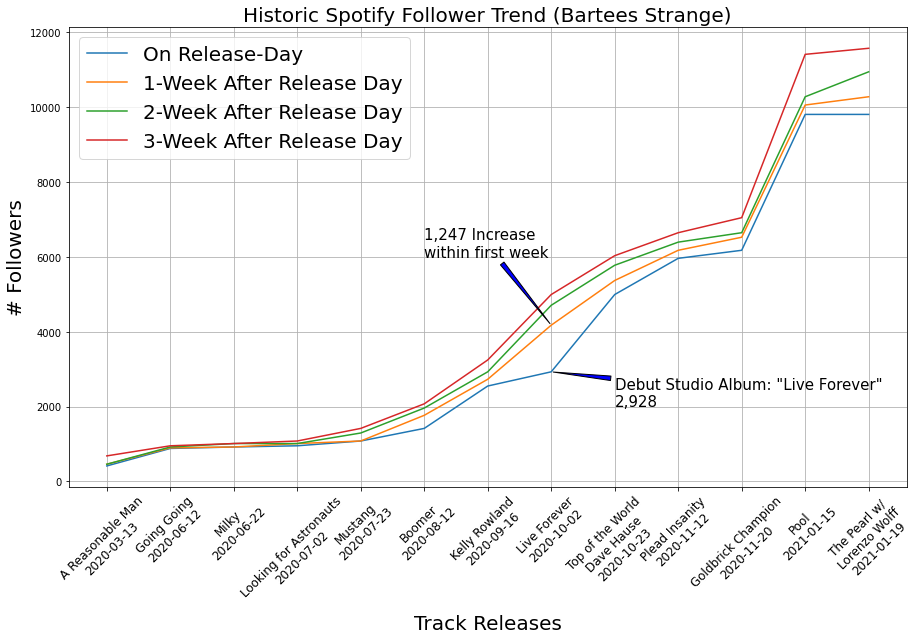

In [38]:
#plot historical followers by release
from matplotlib.pyplot import * 

fig = figure(figsize=(13, 9))  # define the figure window
ax1  = fig.add_subplot(111)   # define the axis
sns.lineplot(x=unique_releases['release_dates'], y=unique_releases['spfollowers'])
sns.lineplot(x=unique_releases['release_dates'], y=unique_releases['spfollowers1wk'])
sns.lineplot(x=unique_releases['release_dates'], y=unique_releases['spfollowers2wk'])
sns.lineplot(x=unique_releases['release_dates'], y=unique_releases['spfollowers3wk'])


plt.annotate('Debut Studio Album: "Live Forever"\n2,928', xy=('2020-10-02',2928), xytext=('2020-10-23', 2000), 
            arrowprops=dict(facecolor='blue', arrowstyle='wedge'), fontsize=15)
plt.annotate("1,247 Increase\nwithin first week", xy=('2020-10-02',4175), xytext=('2020-08-12', 6000), 
            arrowprops=dict(facecolor='blue', arrowstyle='wedge'), fontsize=15)

plt.title('Historic Spotify Follower Trend (Bartees Strange)', fontsize=20)
plt.xlabel('Track Releases', fontsize=20)
locs, labels = xticks()
plt.xticks(ticks=locs,labels=new,rotation=45, fontsize=12)
plt.ylabel('# Followers', fontsize=20)
# plt.tick_params(axis='both', which='major', labelsize=15, rotation=45)
plt.grid(axis='both')
plt.legend(['On Release-Day', '1-Week After Release Day', '2-Week After Release Day', '3-Week After Release Day'],fontsize=20)

plt.tight_layout()
plt.savefig('visuals/bartees_follower_releasetrend.png')

plt.show()

## Spotify Listener Trend

In [174]:
unique_releases['splistenersdiff'] = unique_releases['splisteners'].diff()

In [273]:
# unique_releases.loc[unique_releases['track_title'] == 'Looking for Astronauts']['splisteners']

In [284]:
unique_releases['splisteners1wk'].diff().median()

3922.0

In [422]:
unique_releases

,release_dates,cm_track_id,track_title,isrc,cm_artist_id,sp-rch-1wk,sp-rch-2wk,sp-rch-3wk,ftimestp,spfollowers,...,instagram_followers3wk,spfollowers1wk,spfollowers2wk,spfollowers3wk,splisteners1wk,splisteners2wk,splisteners3wk,first_week_growth,second_week_growth,third_week_growth
index,,,,,,,,,,,,,,,,,,,,,
2,2020-03-13,28764826,A Reasonable Man (I Don't Mind),UST842006405,1399763,0,38,42,2020-03-13,411,...,NaN,457,457,680,12510,12510,17803,46,0,223
3,2020-06-12,28496186,Going Going,UST842006408,1399763,29,29,29,2020-06-12,879,...,NaN,895,918,950,3953,3970,5922,16,23,32
5,2020-06-22,32463895,Milky,USHM22076316,1399763,0,0,0,2020-06-22,918,...,NaN,918,1010,1010,3970,11797,11797,0,92,0
7,2020-07-02,29991711,Looking for Astronauts,UST842006407,1399763,0,0,23747,2020-07-02,950,...,NaN,1010,1010,1078,11797,11797,21661,60,0,68
8,2020-07-23,30360644,Mustang,QMCE71302890,1399763,26778,27316,27754,2020-07-23,1078,...,NaN,1078,1292,1415,21661,34599,40941,0,214,123
9,2020-08-12,30970244,Boomer,QMCE71302891,1399763,2816,2816,2897,2020-08-12,1415,...,NaN,1765,1959,2072,51016,60961,58782,350,194,113
10,2020-09-16,31372321,Kelly Rowland,QMCE71302892,1399763,24355,26606,46681,2020-09-16,2548,...,NaN,2729,2928,3245,45763,47885,54854,181,199,317
18,2020-10-02,22387666,In a Cab,QZDA51900896,1399763,41634,85683,94332,2020-10-02,2928,...,NaN,4175,4707,4994,79662,95657,103169,1247,532,287
19,2020-10-23,31776148,Top of the World (feat. Bartees Strange),QM7282077752,1399763,44504,53609,66018,2020-10-23,4994,...,5182.0,5370,5777,6033,107752,91903,76380,376,407,256


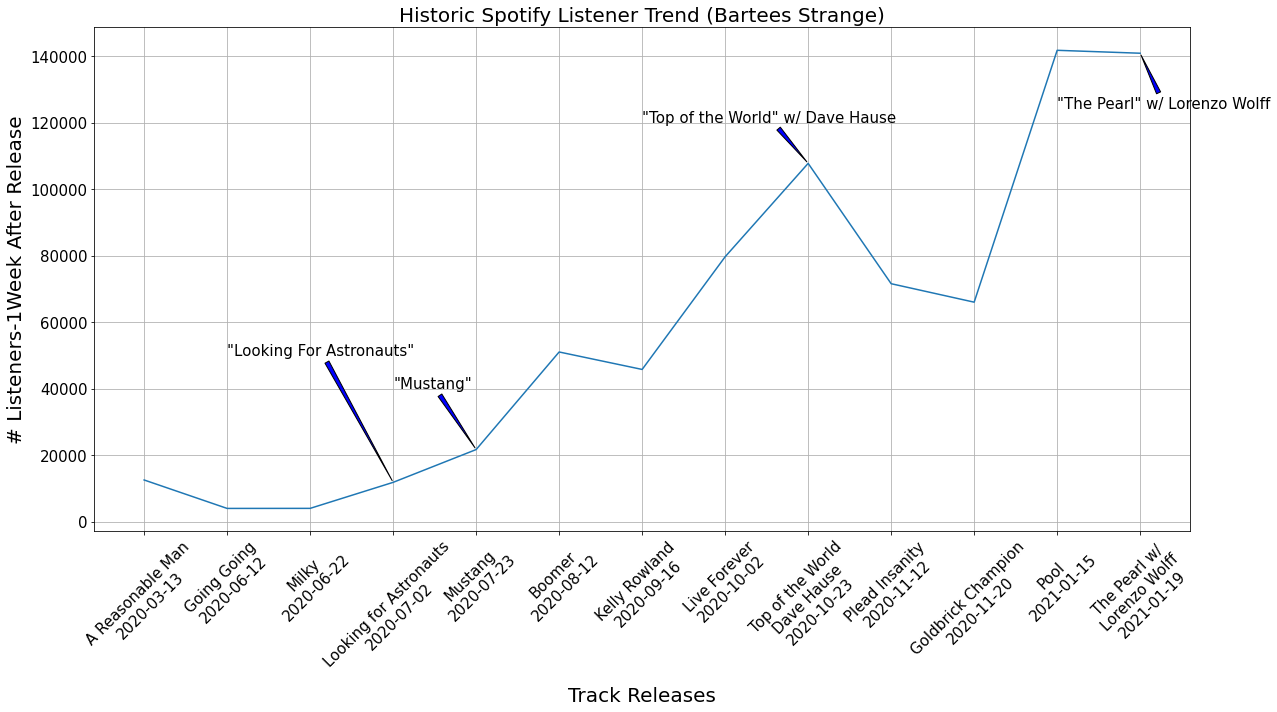

In [423]:
from matplotlib.pyplot import * 

fig = figure(figsize=(18,10))  # define the figure window
ax1  = fig.add_subplot(111)   # define the axis
sns.lineplot(x=unique_releases['release_dates'], y=unique_releases['splisteners1wk'])





plt.annotate('"The Pearl" w/ Lorenzo Wolff', xy=('2021-01-19',140887), xytext=('2021-01-15', 124217), 
            arrowprops=dict(facecolor='blue', arrowstyle='wedge'), fontsize=15)

plt.annotate('"Top of the World" w/ Dave Hause', xy=('2020-10-23',107752), xytext=('2020-09-16', 120169), 
            arrowprops=dict(facecolor='blue', arrowstyle='wedge'), fontsize=15)

plt.annotate('"Mustang"', xy=('2020-07-23',21661), xytext=('2020-07-02', 40000), 
            arrowprops=dict(facecolor='blue', arrowstyle='wedge'), fontsize=15)

plt.annotate('"Looking For Astronauts"', xy=('2020-07-02',11797), xytext=('2020-06-12', 50000), 
            arrowprops=dict(facecolor='blue', arrowstyle='wedge'), fontsize=15)

plt.title('Historic Spotify Listener Trend (Bartees Strange)', fontsize=20)
plt.xlabel('Track Releases', fontsize=20)
locs, labels = xticks()
plt.xticks(ticks=locs,labels=new,rotation=45, fontsize=10)
plt.ylabel('# Listeners-1Week After Release', fontsize=20)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.tick_params(axis='x', which='major', labelsize=15, rotation=45)

plt.grid(axis='both')

plt.tight_layout()
plt.savefig('visuals/bartees_listener_releasetrend.png')

plt.show()

In [453]:
unique_releases['splisteners1wk'][3:].pct_change().median()

0.35261479751951996

In [454]:
unique_releases['splisteners1wk'][0:3].pct_change().median()

-0.3398561292630455

# Twitter Follower Trends by Release

In [39]:
unique_releases.keys()

Index(['release_dates', 'cm_track_id', 'track_title', 'isrc', 'cm_artist_id',
       'sp-rch-1wk', 'sp-rch-2wk', 'sp-rch-3wk', 'ftimestp', 'spfollowers',
       'splisteners', 'sp_fcr', 'daily_diff', 'year-month',
       'twitter_followers', 'twitter_followers1wk', 'twitter_followers2wk',
       'twitter_followers3wk', 'instagram_followers', 'instagram_followers1wk',
       'instagram_followers2wk', 'instagram_followers3wk', 'spfollowers1wk',
       'spfollowers2wk', 'spfollowers3wk', 'splisteners1wk', 'splisteners2wk',
       'splisteners3wk', 'first_week_growth', 'second_week_growth',
       'third_week_growth', 'first_week_listenersgrowth',
       'second_week_listenersgrowth', 'third_week_listenersgrowth'],
      dtype='object')

In [11]:
#list of release track names
release_titles = ['A Reasonable Man','Going Going','Milky','Looking for Astronauts','Mustang','Boomer','Kelly Rowland', 'Live Forever','Top of the World\nDave Hause','Plead Insanity',
          'Goldbrick Champion','Pool','The Pearl w/\nLorenzo Wolff']
#list of release dates
dates = list(unique_releases['release_dates'])
new = []
dates
i=0
for x in release_titles:
    y=x+'\n'+dates[i]
    i+=1
    new.append(y)

In [28]:
unique_releases.loc[unique_releases['track_title'] == 'In a Cab']['twitter_followers1wk']

index
18    4701.0
Name: twitter_followers1wk, dtype: float64

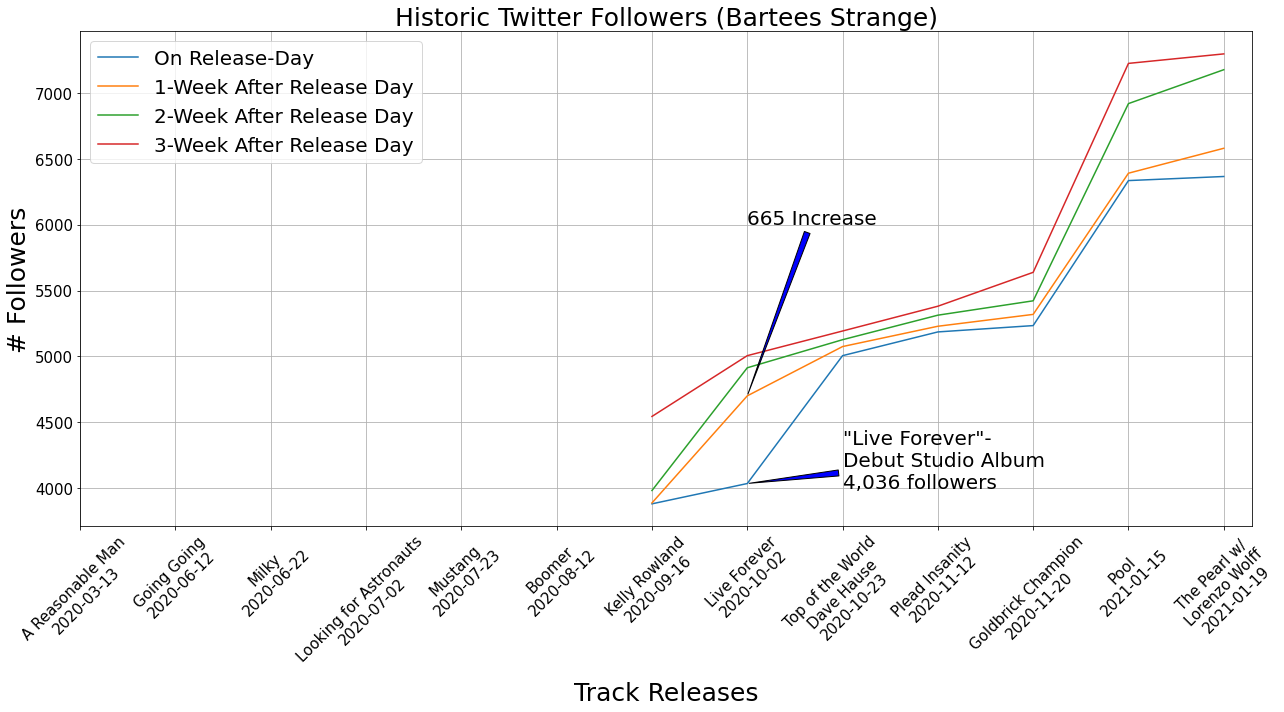

In [37]:
from matplotlib.pyplot import * 

fig = figure(figsize=(18,10))  # define the figure window
ax1  = fig.add_subplot(111)   # define the axis
sns.lineplot(x=unique_releases['release_dates'], y=unique_releases['twitter_followers'])
sns.lineplot(x=unique_releases['release_dates'], y=unique_releases['twitter_followers1wk'])
sns.lineplot(x=unique_releases['release_dates'], y=unique_releases['twitter_followers2wk'])
sns.lineplot(x=unique_releases['release_dates'], y=unique_releases['twitter_followers3wk'])




plt.annotate('"Live Forever"-\nDebut Studio Album\n4,036 followers', xy=('2020-10-02',4036), xytext=('2020-10-23', 4000), 
            arrowprops=dict(facecolor='blue', arrowstyle='wedge'), fontsize=20)
plt.annotate('665 Increase', xy=('2020-10-02',4701), xytext=('2020-10-02', 6000), 
            arrowprops=dict(facecolor='blue', arrowstyle='wedge'), fontsize=20)


plt.title('Historic Twitter Followers (Bartees Strange)', fontsize=25)
plt.xlabel('Track Releases', fontsize=25)
locs, labels = xticks()
plt.xticks(ticks=locs,labels=new,rotation=45, fontsize=10)
plt.ylabel('# Followers', fontsize=25)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.tick_params(axis='x', which='major', labelsize=15, rotation=45)
plt.legend(['On Release-Day', '1-Week After Release Day', '2-Week After Release Day', '3-Week After Release Day'], fontsize=20)

plt.grid(axis='both')

plt.tight_layout()
plt.savefig('visuals/bartees_twitter_releasetrend.png')

plt.show()

In [80]:
unique_releases['first_week_TWgrowth'] = unique_releases['twitter_followers1wk'] - unique_releases['twitter_followers']
unique_releases['second_week_TWgrowth'] = unique_releases['twitter_followers2wk'] - unique_releases['twitter_followers1wk']
unique_releases['third_week_TWgrowth'] = unique_releases['twitter_followers3wk'] - unique_releases['twitter_followers2wk']

In [81]:
#Median 1st Week Net Gain
unique_releases['first_week_TWgrowth'].median()

69.0

In [82]:
unique_releases['second_week_TWgrowth'].median()

103.0

In [83]:
unique_releases['third_week_TWgrowth'].median()

120.0

# Instagram Follower Trend by Release

In [40]:
unique_releases.keys()

Index(['release_dates', 'cm_track_id', 'track_title', 'isrc', 'cm_artist_id',
       'sp-rch-1wk', 'sp-rch-2wk', 'sp-rch-3wk', 'ftimestp', 'spfollowers',
       'splisteners', 'sp_fcr', 'daily_diff', 'year-month',
       'twitter_followers', 'twitter_followers1wk', 'twitter_followers2wk',
       'twitter_followers3wk', 'instagram_followers', 'instagram_followers1wk',
       'instagram_followers2wk', 'instagram_followers3wk', 'spfollowers1wk',
       'spfollowers2wk', 'spfollowers3wk', 'splisteners1wk', 'splisteners2wk',
       'splisteners3wk', 'first_week_growth', 'second_week_growth',
       'third_week_growth', 'first_week_listenersgrowth',
       'second_week_listenersgrowth', 'third_week_listenersgrowth'],
      dtype='object')

In [62]:
unique_releases.iloc[:, 12:]

,daily_diff,year-month,twitter_followers,twitter_followers1wk,twitter_followers2wk,twitter_followers3wk,instagram_followers,instagram_followers1wk,instagram_followers2wk,instagram_followers3wk,...,spfollowers3wk,splisteners1wk,splisteners2wk,splisteners3wk,first_week_growth,second_week_growth,third_week_growth,first_week_listenersgrowth,second_week_listenersgrowth,third_week_listenersgrowth
index,,,,,,,,,,,,,,,,,,,,,
2,6.0,2020-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,680,12510,12510,17803,46,0,223,4186,0,5293
3,2.0,2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,950,3953,3970,5922,16,23,32,-180,17,1952
5,5.0,2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1010,3970,11797,11797,0,92,0,0,7827,0
7,3.0,2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1078,11797,11797,21661,60,0,68,5875,0,9864
8,4.0,2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1415,21661,34599,40941,0,214,123,0,12938,6342
9,11.0,2020-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2072,51016,60961,58782,350,194,113,10075,9945,-2179
10,11.0,2020-09,3882.0,3889.0,3983.0,4545.0,NaN,NaN,NaN,NaN,...,3245,45763,47885,54854,181,199,317,-4025,2122,6969
18,0.0,2020-10,4036.0,4701.0,4914.0,5006.0,NaN,NaN,NaN,NaN,...,4994,79662,95657,103169,1247,532,287,31777,15995,7512
19,0.0,2020-10,5006.0,5075.0,5127.0,5193.0,NaN,NaN,5098.0,5182.0,...,6033,107752,91903,76380,376,407,256,4583,-15849,-15523


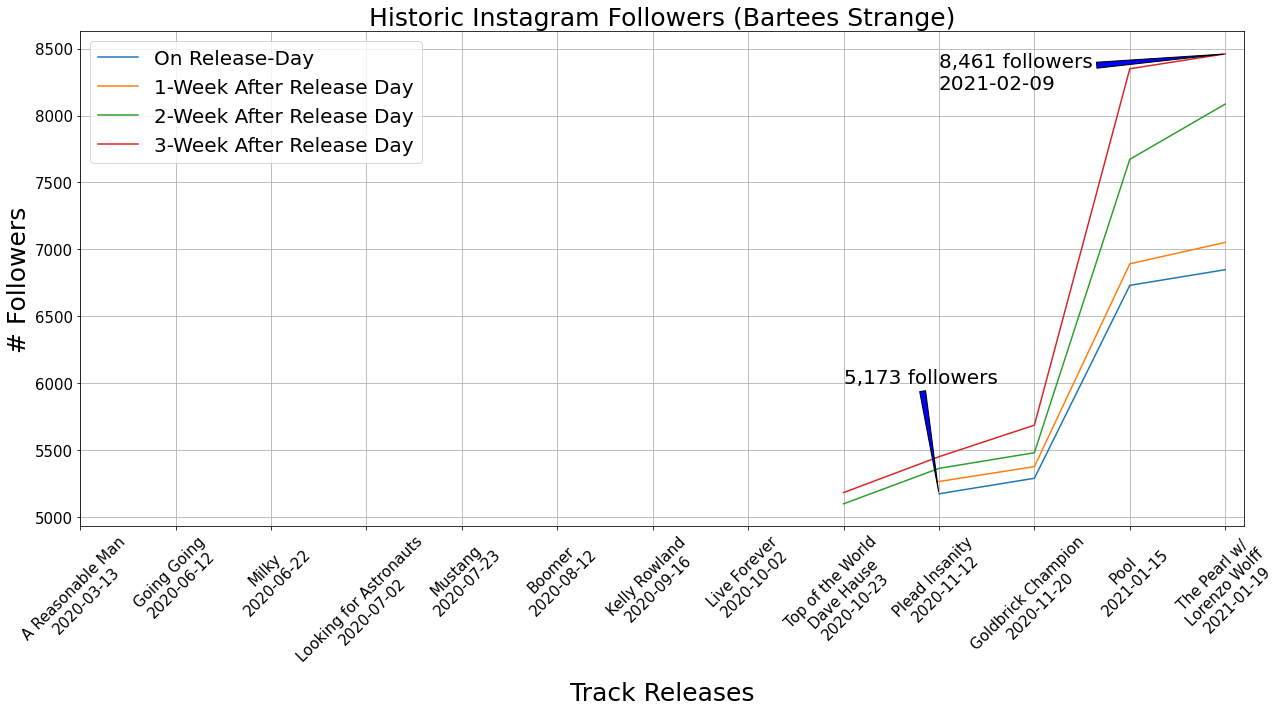

In [73]:
#plot historical followers by release
from matplotlib.pyplot import * 

fig = figure(figsize=(18,10))  # define the figure window
ax1  = fig.add_subplot(111)   # define the axis
sns.lineplot(x=unique_releases['release_dates'], y=unique_releases['instagram_followers'])
sns.lineplot(x=unique_releases['release_dates'], y=unique_releases['instagram_followers1wk'])
sns.lineplot(x=unique_releases['release_dates'], y=unique_releases['instagram_followers2wk'])
sns.lineplot(x=unique_releases['release_dates'], y=unique_releases['instagram_followers3wk'])


plt.annotate('5,173 followers', xy=('2020-11-12',5173), xytext=('2020-10-23', 6000), 
            arrowprops=dict(facecolor='blue', arrowstyle='wedge'), fontsize=20)
plt.annotate("8,461 followers\n2021-02-09", xy=('2021-01-19',8461), xytext=('2020-11-12', 8200), 
            arrowprops=dict(facecolor='blue', arrowstyle='wedge'), fontsize=20)

plt.title('Historic Instagram Followers (Bartees Strange)', fontsize=25)
plt.xlabel('Track Releases', fontsize=25)
locs, labels = xticks()
plt.xticks(ticks=locs,labels=new,rotation=45, fontsize=15)
plt.ylabel('# Followers', fontsize=25)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.tick_params(axis='x', which='major', labelsize=15, rotation=45)
plt.grid(axis='both')
plt.legend(['On Release-Day', '1-Week After Release Day', '2-Week After Release Day', '3-Week After Release Day'],fontsize=20)

plt.tight_layout()
plt.savefig('visuals/bartees_igfollower_releasetrend.png')

plt.show()

In [75]:
unique_releases['first_week_IGgrowth'] = unique_releases['instagram_followers1wk'] - unique_releases['instagram_followers']
unique_releases['second_week_IGgrowth'] = unique_releases['instagram_followers2wk'] - unique_releases['instagram_followers1wk']
unique_releases['third_week_IGgrowth'] = unique_releases['instagram_followers3wk'] - unique_releases['instagram_followers2wk']

In [79]:
#Median 1st Week Net Gain
unique_releases['third_week_IGgrowth'].median()

206.0

In [74]:
unique_releases.keys()

Index(['release_dates', 'cm_track_id', 'track_title', 'isrc', 'cm_artist_id',
       'sp-rch-1wk', 'sp-rch-2wk', 'sp-rch-3wk', 'ftimestp', 'spfollowers',
       'splisteners', 'sp_fcr', 'daily_diff', 'year-month',
       'twitter_followers', 'twitter_followers1wk', 'twitter_followers2wk',
       'twitter_followers3wk', 'instagram_followers', 'instagram_followers1wk',
       'instagram_followers2wk', 'instagram_followers3wk', 'spfollowers1wk',
       'spfollowers2wk', 'spfollowers3wk', 'splisteners1wk', 'splisteners2wk',
       'splisteners3wk', 'first_week_growth', 'second_week_growth',
       'third_week_growth', 'first_week_listenersgrowth',
       'second_week_listenersgrowth', 'third_week_listenersgrowth'],
      dtype='object')

# Fresh Finds: Rock Playlist

In [253]:
#collect raw data
ffrock_tracks = get_playlist_tracks(api_token, 'spotify', 1676389, 'current', 'us')

In [291]:
bucket = []
for track in ffrock_tracks:
    tup = (track['added_at'], track['cm_track'], track['name'], track['cm_artist'], track['spotify_artist_names'], track['release_dates'],
          track['period'])
    bucket.append(tup)
    
fresh_finds_current = pd.DataFrame(bucket, columns=['added_at', 'cm_track', 'title', 'cm_artist', 'artists', 'release_date', 'days_on_playlist'])


In [293]:
fresh_finds_current['artist1'] = fresh_finds_current['artists'].apply(lambda x: x[0])
fresh_finds_current['artist2'] = fresh_finds_current['artists'].apply(lambda x: x[1] if len(x) > 1 else None)

fresh_finds_current['release_date'] = fresh_finds_current['release_date'].apply(lambda x: x[0])
fresh_finds_current['cm_artist1'] = fresh_finds_current['cm_artist'].apply(lambda x: x[0])
fresh_finds_current['cm_artist2'] = fresh_finds_current['cm_artist'].apply(lambda x: x[1] if len(x) > 1 else None)

In [297]:
#convert datetime object
fresh_finds_current['release_date'] = pd.to_datetime(fresh_finds_current['release_date']).dt.date
fresh_finds_current['added_at'] = pd.to_datetime(fresh_finds_current['added_at']).dt.date

## Fan Conversion Ratio
`sp_fcr_art1` for artist 1

In [317]:
#get spotify follower data for each artist one week before playlist add
bucket = []
for artist in fresh_finds_current.iterrows():
    add_date = str(artist[1]['added_at'])
    one_wkprior = str(artist[1]['added_at'] - datetime.timedelta(days=7))
    artist_id = artist[1]['cm_artist1']
    data = get_fan_metrics(api_token, artist_id, 'spotify', one_wkprior, add_date, field='listeners')['listeners']
    if len(data) > 0:
        bucket.append(data[0]['value'])
    else:
        bucket.append(None)

In [318]:
# fresh_finds_current['spf_art1'] = bucket
fresh_finds_current['spl_art1'] = bucket

In [63]:
#Calculate spotify follower conversion `sp_fcr_art1`

fresh_finds_current['sp_fcr_art1'] = (fresh_finds_current['spf_art1'] / fresh_finds_current['spl_art1'])*100


In [72]:
#get spotify follower data for each artist one week before playlist add
bucket = []
for artist in fresh_finds_current.loc[fresh_finds_current['cm_artist2'] > 0].iterrows():
    add_date = str(artist[1]['added_at'])[:10]
    one_wkprior = str(artist[1]['added_at'] - datetime.timedelta(days=7))[:10]
    artist_id = remove_trailing_zeros(artist[1]['cm_artist2'])
    data = get_fan_metrics(api_token, artist_id, 'spotify', one_wkprior, add_date, field='listeners')['listeners']
    if len(data) > 0:
        bucket.append(data[0]['value'])
    else:
        bucket.append(None)

In [73]:
cm_artist2_list = fresh_finds_current.loc[fresh_finds_current['cm_artist2'] > 0]['cm_artist2']


In [47]:
artist2listener_di = dict(zip(cm_artist2_list,bucket))

In [75]:
# fresh_finds_current['spf_art1'] = bucket
fresh_finds_current['spl_art2'] = fresh_finds_current['cm_artist2'].map(artist2listener_di)


## Bartees Strange - FCR

In [76]:
fresh_finds_current['sp_fcr_art2'] = (fresh_finds_current['spf_art2'] / fresh_finds_current['spl_art2'])*100


255

In [108]:
fresh_finds_current['spf_art1'].median()

641.5

In [109]:
insert_thousands_commas(fresh_finds_current.loc[fresh_finds_current['artist2']=='Bartees Strange']['spf_art2'].values[0])


'10,282'

/home/bull/Documents/practice1/test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


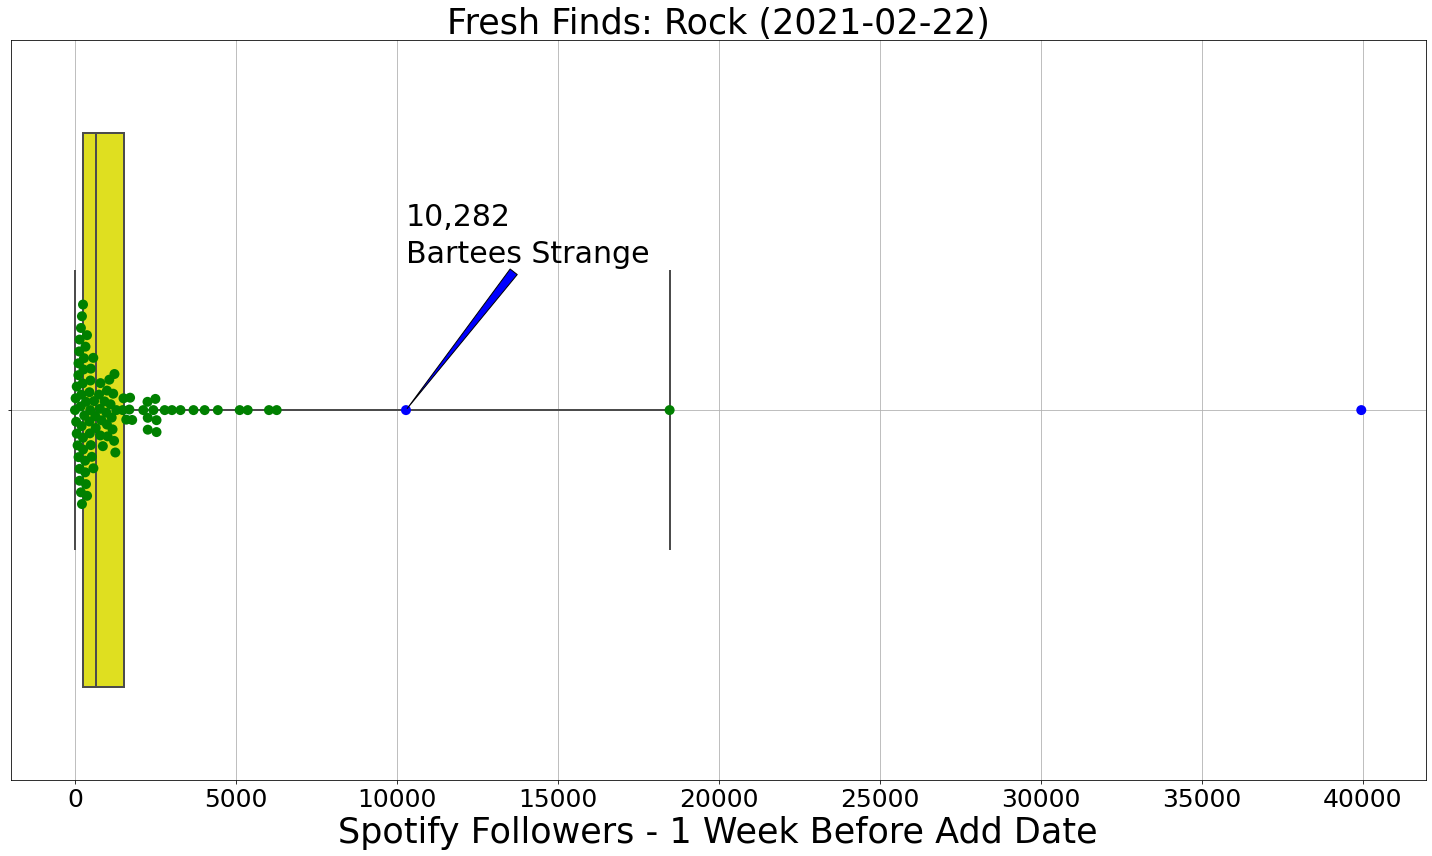

In [107]:
from matplotlib.pyplot import * 

fig = figure(figsize=(20,12))  # define the figure window
ax1  = fig.add_subplot(111)   # define the axis
sns.boxplot(fresh_finds_current['spf_art1'], fliersize=1,linewidth=2, whis=30,width=.75, color='yellow')
#markers with just twitter
sns.swarmplot(data=fresh_finds_current,x=fresh_finds_current['spf_art1'], color='green', size=10)
sns.swarmplot(data=fresh_finds_current,x=fresh_finds_current['spf_art2'], color='blue', size=10)






plt.title('Fresh Finds: Rock (2021-02-22)', fontsize=35)
plt.xlabel('Spotify Followers - 1 Week Before Add Date', fontsize=35)
plt.ticklabel_format(style='plain', axis='x') #change xaxis from sci to plain style

plt.annotate('Bartees Strange', xy=(fresh_finds_current.loc[fresh_finds_current['artist2']=='Bartees Strange']['spf_art2'], 0), xytext=(fresh_finds_current.loc[fresh_finds_current['artist2']=='Bartees Strange']['spf_art2'], -.2),
            arrowprops=dict(facecolor='blue', arrowstyle='wedge'), fontsize=30)
plt.annotate(insert_thousands_commas(fresh_finds_current.loc[fresh_finds_current['artist2']=='Bartees Strange']['spf_art2'].values[0])
, xy=(fresh_finds_current.loc[fresh_finds_current['artist2']=='Bartees Strange']['spf_art2'], 0), xytext=(fresh_finds_current.loc[fresh_finds_current['artist2']=='Bartees Strange']['spf_art2'], -.25),
             fontsize=30)



plt.tick_params(axis='x', which='major', labelsize=25)
plt.grid(axis='both')

plt.tight_layout()
plt.savefig('visuals/freshfinds_followers_bp.png')

plt.show()

# Save Fresh Finds Dataset

In [110]:
fresh_finds_current.to_csv('data/freshfinds_rock.csv', index_label='index')

# Read In Dataset

In [4]:
fresh_finds_current = pd.read_csv('data/freshfinds_rock.csv', sep = ',',encoding='utf-8-sig', index_col='index', parse_dates=['added_at', 'release_date'])    


In [ ]:
|